In [2]:
#import all the modules that we need for the analysis
from __future__ import print_function, absolute_import, division
##imports
import os
from scipy.interpolate import PchipInterpolator

import requests
import numpy as np
import pandas as pd
#import seaborn as sb
import astropy.io.fits as pf
import matplotlib.pyplot as plt
%matplotlib notebook
#froms from standards
import astropy
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib import cm
from scipy.signal import medfilt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter

#froms from non-standards
#from astroquery.mast import Catalogs
from lightkurve import TessTargetPixelFile
#from tess_stars2px import tess_stars2px_function_entry
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from glob import glob

from numpy import exp, loadtxt, pi, sqrt
#from lmfit import Model
from matplotlib import rc
from astropy.modeling import models, fitting
import numpy as np

In [3]:
section_number = 3

In [4]:
#file = "/Users/Nora/Documents/research/TESS/planethunters/code/LATTE/LATTE/LATTE_output/470710327/470710327_data.txt"
#data = pd.read_csv(file, comment = '#', delimiter= '\t', names = ['time', 'flux', 'err' ], skiprows = 1)

In [10]:
import lightkurve as lk 

search_result = lk.search_lightcurve('TIC 470710327', author = 'SPOC').download_all().stitch()
search_result

alltime = search_result.time.value
allflux = search_result.flux.value
allerr = search_result.flux_err.value


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 67,2023,SPOC,120,277039287,0.0


(1756.2700000000186, 1776.2700000000186)

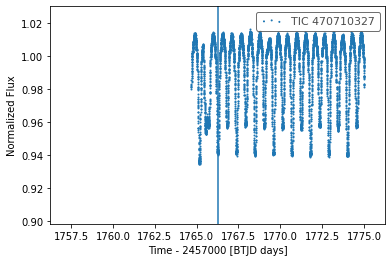

In [5]:
%matplotlib inline 

fig,ax = plt.subplots()

search_result.scatter(ax = ax)

ax.axvline(2458766.2700 - 2457000)
plt.xlim(2458766.2700 - 2457000 - 10, 2458766.2700 - 2457000 + 10)


(-0.05, 0.05)

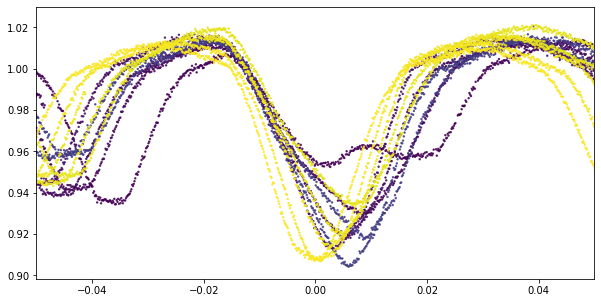

In [6]:
period = 1.1047115
t0 = 1766.267

period_9 = 9.9732
t0_9 = 1795.45 - (period_9 * 3)

phased = np.array([-0.5+( ( t - t0_9-0.5*period_9) % period_9) / period_9 for t in alltime])

fig, ax = plt.subplots(figsize = (10,5))

plt.scatter(phased,allflux, s = 2, alpha = 0.8, c = alltime)

plt.xlim(-0.05,0.05)

In [7]:
def sort_on_x(x,y):
    zipped = list(zip(x,y))
    zipped.sort(key=lambda x:x[0])
    x,y = list(zip(*zipped))
    return x,y


def run_binning(x,y,yerr=None,nbins=100,alias=False):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    x = np.array(x)
    y = np.array(y)
    
    finite_mask = np.isfinite(x) * np.isfinite(y)
    
    x = x[finite_mask]
    y = y[finite_mask]
    
    bwidth = 1./nbins
    if alias==True:
        phStart,phStop = -0.6,0.6
    else:
        phStart,phStop = -0.5,0.5

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
        
    return bwidth,bins,bin_means,bin_errs


def time_to_ph(time, period=1., t0=0., pshift=0.):
    '''
    converts time to phase from input ephemeris
    DOES NOT ACCOUNT FOR BARYCENTRIC OR HELIOCENTRIC CORRECTION

    input: time (float or array)  --> time point or array
    input: period (float)
    input: t0 (float)
    input: pshift (float) --> phase shift
    ------
    output: phase (float or array)
    '''
    time = np.array(time)
    ph = np.mod((time-t0)/period, 1.0) + pshift
    ph[ph < 0.0] += 1.
    ph[ph > 0.5] -= 1.

    return ph


def interpolate_signal(x_indep,x_model,y_model,nbins):

    bin_width,bin_edges,bin_means,_ = run_binning(x_model,y_model,nbins=nbins)
    bins = bin_edges[:-1]+0.5*bin_width

    interpolated_model = PchipInterpolator(bins,bin_means,extrapolate=False)
    interpolated_y = interpolated_model(x_indep)

    return interpolated_y,interpolated_model


def model_signal(period,t0,x,y,x1=None,y1=None,nbins=100):

    ph_x = time_to_ph(x,period,t0)
    ph_x_sorted,y_sorted = sort_on_x(ph_x,y)
    y_interpolated, model = interpolate_signal(ph_x,ph_x_sorted,y_sorted,nbins)

    y_model_subtracted = y-y_interpolated

    return y_model_subtracted, y_interpolated, model


def trend_removal_interact(period_a, t0_a, times_original, flux_original, time_cut, flux_cut, nbins = 100):

    #rc('text', usetex=True)
    #rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    #plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
    #plt.rcParams['xtick.labelsize']=18
    #plt.rcParams['ytick.labelsize']=18


    flux_cut_sub_period_a, flux_cut_period_a_model,\
    flux_cut_period_a_function = model_signal(period_a, t0_a,time_cut,flux_cut, nbins)
    
    ph_original = time_to_ph(times_original,period_a,t0_a)
    ph_cut = time_to_ph(time_cut,period_a,t0_a)
    
    flux_original_period_a_model = flux_cut_period_a_function(ph_original)
    flux_original_sub_period_a = flux_original - np.array(flux_original_period_a_model)
    
    fig,axes = plt.subplots(2,1, figsize = (7,8))
    fig.subplots_adjust(bottom=0.2)

    axes[0].plot(ph_original,flux_original,marker = '.', lw = 0, color = 'grey')
    axes[0].plot(ph_cut,flux_cut,marker = '.', lw = 0, color = 'k')
    
    axes[0].plot(ph_original,flux_original_period_a_model,marker = '.', lw = 0, color = 'darkorange', ms = 2)
    
    
    axes[1].plot(ph_original,flux_original_sub_period_a,'k.', alpha = 0.5)
    
    axes[0].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_xlabel(r'$\Phi$',fontsize=18)
    
    
    axes[0].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[0].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[0].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[0].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')

    axes[1].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[1].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[1].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[1].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')


    #plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/sig_removal.png', dpi = 300)
    plt.show()  
    
    return ph_original,times_original, flux_original_sub_period_a, flux_original_period_a_model, ph_cut, flux_cut


In [8]:
data = {'time': search_result.time.value, 'flux': search_result.flux.value, 'err': search_result.flux_err.value}

time_cut_w9 = search_result.time.value
flux_cut_w9 = search_result.flux.value
err_cut_w9 = search_result.flux_err.value

#time_cut_w9 = data['time']
#flux_cut_w9 = data['flux']
#err_cut_w9 = data['err']

new_mask_w9 = (time_cut_w9 > 1790 ) & (time_cut_w9 < 1792) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]

new_mask_w9 = (time_cut_w9 > 1814 ) & (time_cut_w9 < 1815) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]


In [9]:
time_cut = time_cut_w9
flux_cut = flux_cut_w9
err_cut = err_cut_w9

for i in range(0,1030):
    
    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))

    time_cut = time_cut[~mask]
    flux_cut = flux_cut[~mask]
    err_cut = err_cut[~mask]
    
new_mask = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

new_mask = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

#plt.figure(figsize=(10,5))
#
#plt.plot(time_cut, flux_cut, '.', color ='red')

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/sec24_sig_rem.txt", np.array([time_cut[new_sec_mask], flux_cut[new_sec_mask], (flux_cut[new_sec_mask]/flux_cut[new_sec_mask]*0.001)]).T)

#plt.xlim(1955.4,1960)

period = period
t0 = 1766.267

#for i in range(0,1200):
#    plt.axvline(t0 + i * period, color = 'gold', alpha = 0.1)

#plt.show()


period_a = 1.104686
t0_a = 0.

good_mask = np.isfinite(np.array(data['time'])) * np.isfinite(np.array(data['flux'])) 

alltime_ar = np.array(data['time'])[good_mask]
allflux_ar = np.array(data['flux'])[good_mask]

good_mask_cut = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 
good_mask_cut_w9 = np.isfinite(np.array(time_cut_w9)) * np.isfinite(np.array(flux_cut_w9)) 


alltime_ar_cut = np.array(time_cut)[good_mask_cut]
allflux_ar_cut = np.array(flux_cut)[good_mask_cut]

alltime_ar_cut_w9 = np.array(time_cut_w9)[good_mask_cut_w9]
allflux_ar_cut_w9 = np.array(flux_cut_w9)[good_mask_cut_w9]

#plt.scatter(time_cut_w9, flux_cut_w9, s = 1)



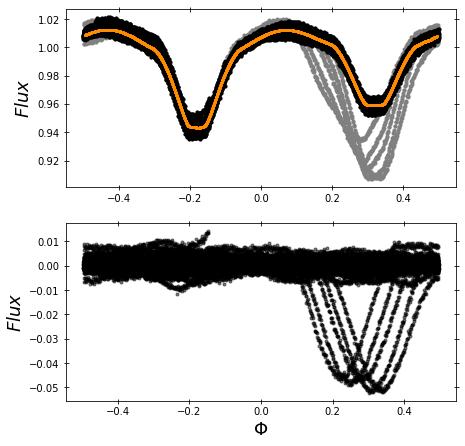

In [10]:
cut_times = [1762, 1820, 1997.6, 2913.3] #[1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]
color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']


#fig, ax = plt.subplots()
mask = (alltime_ar_cut > cut_times[section_number]) & (alltime_ar_cut < cut_times[section_number+1])
mask_w9 = (alltime_ar_cut_w9 > cut_times[section_number]) & (alltime_ar_cut_w9 < cut_times[section_number+1])


#plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)
#plt.show()
alltime_ar_cut_w9 = alltime_ar_cut_w9[mask_w9]
allflux_ar_cut_w9 = allflux_ar_cut_w9[mask_w9]

    
alltime_ar_cut = alltime_ar_cut[mask]
allflux_ar_cut = allflux_ar_cut[mask]

ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, alltime_ar_cut_w9, allflux_ar_cut_w9, alltime_ar_cut, allflux_ar_cut)
    
    
    


In [11]:
# cut_times = [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]
# color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']

# ph_original = []
# times_original = []
# flux_original_sub_period_a = []
# model = []
# ph_cut = []
# flux_cut = []
    
# for i in range(0,len(cut_times)-1):
#     #fig, ax = plt.subplots()
    
#     mask = (alltime_ar_cut > cut_times[i]) & (alltime_ar_cut < cut_times[i+1])
#     mask_w9 = (alltime_ar_cut_w9 > cut_times[i]) & (alltime_ar_cut_w9 < cut_times[i+1])

#     #plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)
#     #plt.show()
#     alltime_ar_cut_w9_temp = alltime_ar_cut_w9[mask_w9]
#     allflux_ar_cut_w9_temp = allflux_ar_cut_w9[mask_w9]

#     if len(alltime_ar_cut_w9_temp) == 0:
#         continue
#     alltime_ar_cut_temp = alltime_ar_cut[mask]
#     allflux_ar_cut_temp = allflux_ar_cut[mask]

#     period = 1.1047115
#     t0 = 1766.267

#     #phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in alltime_ar_cut_temp])
#     #
#     #fig, ax = plt.subplots()
#     #
#     #plt.scatter(phased,allflux_ar_cut_temp, s = 2, alpha = 0.8, c = alltime_ar_cut_temp)
#     #
#     #plt.xlim(-0.15,0.15)

#     ph_original_temp, times_original_temp, flux_original_sub_period_a_temp, model_temp, ph_cut_temp, flux_cut_temp = trend_removal_interact(period_a, 0.1, alltime_ar_cut_w9_temp, allflux_ar_cut_w9_temp, alltime_ar_cut_temp, allflux_ar_cut_temp)
    
#     ph_original.append(ph_original_temp)
#     times_original.append(times_original_temp)
#     flux_original_sub_period_a.append(flux_original_sub_period_a_temp)
#     model.append(model_temp)
#     ph_cut.append(ph_cut_temp)
#     flux_cut.append(flux_cut_temp)
    
    
    
# ph_original = np.hstack(ph_original)
# times_original = np.hstack(times_original)
# flux_original_sub_period_a = np.hstack(flux_original_sub_period_a)
# model = np.hstack(model)
# ph_cut = np.hstack(ph_cut)
# flux_cut = np.hstack(flux_cut)
    

In [12]:
'''
plt.plot(data['time'], data['flux'], '.', alpha = 0.5)

time_cut = time_cut_w9
flux_cut = flux_cut_w9
err_cut = err_cut_w9

for i in range(0,1030):
    
    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))

    time_cut = time_cut[~mask]
    flux_cut = flux_cut[~mask]
    err_cut = err_cut[~mask]
    
new_mask = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

new_mask = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

#new_sec_mask = time_cut>1900

plt.figure(figsize=(10,5))

plt.plot(time_cut, flux_cut, '.', color ='red')

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/sec24_sig_rem.txt", np.array([time_cut[new_sec_mask], flux_cut[new_sec_mask], (flux_cut[new_sec_mask]/flux_cut[new_sec_mask]*0.001)]).T)

#plt.xlim(1955.4,1960)

period = period
t0 = 1766.267

for i in range(0,1200):
    plt.axvline(t0 + i * period, color = 'gold', alpha = 0.1)

plt.show()


from scipy.interpolate import PchipInterpolator

period_a = 1.104686
t0_a = 0.

good_mask = np.isfinite(np.array(data['time'])) * np.isfinite(np.array(data['flux'])) 

alltime_ar = np.array(data['time'])[good_mask]
allflux_ar = np.array(data['flux'])[good_mask]

good_mask_cut = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 
good_mask_cut_w9 = np.isfinite(np.array(time_cut_w9)) * np.isfinite(np.array(flux_cut_w9)) 


alltime_ar_cut = np.array(time_cut)[good_mask_cut]
allflux_ar_cut = np.array(flux_cut)[good_mask_cut]

alltime_ar_cut_w9 = np.array(time_cut_w9)[good_mask_cut_w9]
allflux_ar_cut_w9 = np.array(flux_cut_w9)[good_mask_cut_w9]


ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, alltime_ar_cut_w9, allflux_ar_cut_w9, alltime_ar_cut, allflux_ar_cut)

'''

'\nplt.plot(data[\'time\'], data[\'flux\'], \'.\', alpha = 0.5)\n\ntime_cut = time_cut_w9\nflux_cut = flux_cut_w9\nerr_cut = err_cut_w9\n\nfor i in range(0,1030):\n    \n    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))\n\n    time_cut = time_cut[~mask]\n    flux_cut = flux_cut[~mask]\n    err_cut = err_cut[~mask]\n    \nnew_mask = (time_cut > 1790 ) & (time_cut < 1792) \ntime_cut = time_cut[~new_mask]\nflux_cut = flux_cut[~new_mask]\nerr_cut = err_cut[~new_mask]\n\nnew_mask = (time_cut > 1814 ) & (time_cut < 1815) \ntime_cut = time_cut[~new_mask]\nflux_cut = flux_cut[~new_mask]\nerr_cut = err_cut[~new_mask]\n\n#new_sec_mask = time_cut>1900\n\nplt.figure(figsize=(10,5))\n\nplt.plot(time_cut, flux_cut, \'.\', color =\'red\')\n\n#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/sec24_sig_rem.txt", np.array([time_cut[new_sec_mask], flux_cut[new_sec_mask], (flux_cut[new_sec_mask]/flux_cut[new_sec_mask]*0.001)]).T)\n\

In [13]:
# Remove the overall trend and then re do the fitting to remoe the signal to see whether we can improve on the trend removal

import filters
import norm

times_cut = times_original
flux_cut = flux_original_sub_period_a

T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)


10 37100 451
reached the end
NIF: 0 0 -1 0.001095632383218422
10 35145 451
reached the end
NIF: 1 2321 0 0.0010090730902663585
10 34756 451
reached the end
NIF: 2 2710 2321 0.0009962678474010106
10 34685 451
reached the end
NIF: 3 2781 2710 0.000993881011086834
10 34671 451
reached the end
NIF: 4 2795 2781 0.0009930413985803379


37466 37466
10 37100 1351
reached the end
NIF: 0 0 -1 0.0011988929773885408
10 34841 1351
reached the end
NIF: 1 2625 0 0.0010968727401252268
10 34511 1351
reached the end
NIF: 2 2955 2625 0.0010842594958526959
10 34375 1351
reached the end
NIF: 3 3091 2955 0.0010815372091774113
10 34273 1351
reached the end
NIF: 4 3193 3091 0.0010790122866796308


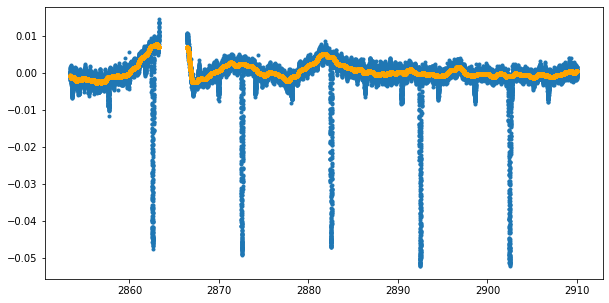

In [14]:
from scipy.interpolate import interp1d
g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_cut)
plt.figure(figsize=(10,5))
plt.plot(times_cut,flux_cut,'.')
plt.plot(times_cut,ff,'.', color = 'orange')
print(np.isfinite(ff).sum(),len(ff))

T_dur = 15

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)

g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_original)


37466 37466


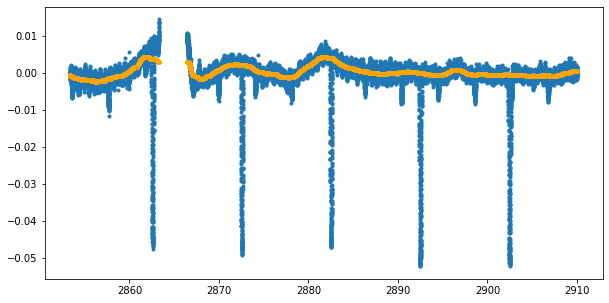

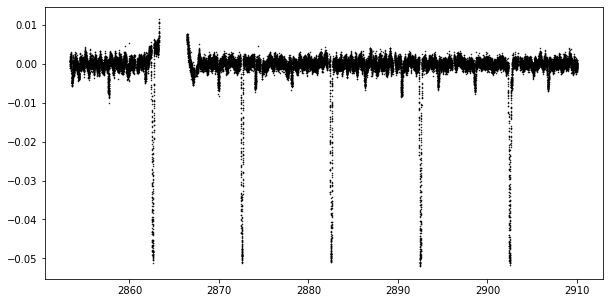

In [15]:
plt.figure(figsize=(10,5))

#plt.plot(alltime_ar_cut,allflux_ar_cut,'.', color = 'k', ms = 1) 

print(np.isfinite(ff).sum(),len(ff))

plt.plot(times_cut,flux_cut,'.')
plt.plot(times_original,ff,'.', color = 'orange')

flux_detrended_sig_rem = flux_cut - ff
time_detrended_sig_rem = times_original

fig, ax = plt.subplots(figsize=(10,5))

#plt.plot(alltime_ar_cut_w9, allflux_ar_cut_w9,'.k', ms = 1)
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.k', alpha = 1, ms = 1)



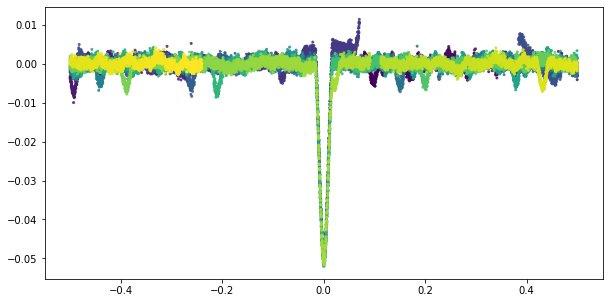

In [16]:
# check the period again herer


phased = np.array([-0.5+( ( t - t0_9-0.5*period_9) % period_9) / period_9 for t in time_detrended_sig_rem])

fig, ax = plt.subplots(figsize = (10,5))

plt.scatter(phased,flux_detrended_sig_rem, s = 4, alpha = 0.8, c = time_detrended_sig_rem)

#plt.xlim(-0.05,0.05)


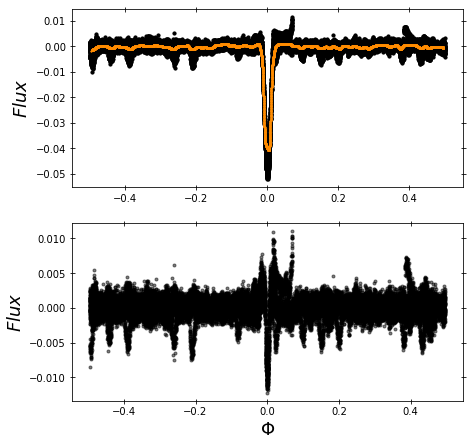

In [17]:
time_detrended_sig_rem
flux_detrended_sig_rem

finite_mask = np.isfinite(time_detrended_sig_rem) * np.isfinite(flux_detrended_sig_rem)

time_detrended_sig_rem_finite = time_detrended_sig_rem[finite_mask]
flux_detrended_sig_rem_finite = flux_detrended_sig_rem[finite_mask]


ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_9, t0_9, time_detrended_sig_rem, flux_detrended_sig_rem, time_detrended_sig_rem, flux_detrended_sig_rem, nbins = 100)




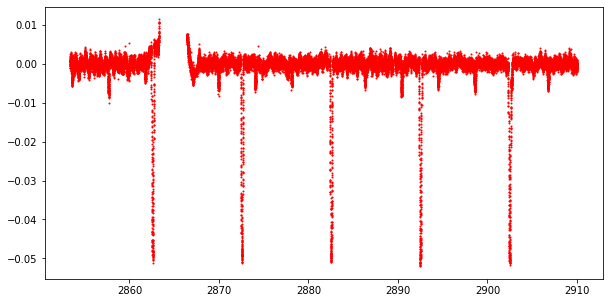

In [18]:
%matplotlib inline

plt.figure(figsize=(10,5))

plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.r', alpha = 1, ms = 2)

plt.show()

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/LC_9d_4d_sig_only.txt", np.array([time_detrended_sig_rem, flux_detrended_sig_rem]).T)

In [19]:
import statsmodels.api as sm

In [20]:
lowess = sm.nonparametric.lowess


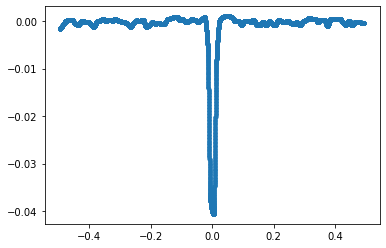

In [21]:

plt.plot(ph_original, model, lw = 0, marker = '.')   

model_smooth = lowess(model, ph_original, return_sorted = True, frac = 0.01, it = 5)

model_smooth_x = model_smooth[:,0]
model_smooth_y = model_smooth[:,1]

gradient = np.gradient(model_smooth_y, model_smooth_x)



In [22]:
gradient_smooth0 = lowess(gradient, model_smooth_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth0_x = gradient_smooth0[:,0]
gradient_smooth0_y = gradient_smooth0[:,1]

gradient_smooth = lowess(gradient_smooth0_y, gradient_smooth0_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth_x = gradient_smooth[:,0]
gradient_smooth_y = gradient_smooth[:,1]


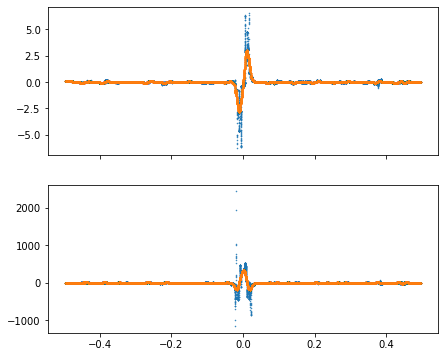

In [23]:
fig,ax = plt.subplots(2,1, figsize = (7,6), sharex = True)

ax[0].plot(model_smooth_x, gradient, lw = 0, marker = '.', ms = 1)
ax[0].plot(gradient_smooth_x, gradient_smooth_y, lw = 0, marker = '.', ms = 1)

derif2 = np.gradient(gradient_smooth_y, gradient_smooth_x)

derif2_smooth = lowess(derif2, gradient_smooth_x, return_sorted = True, frac = 0.01, it = 5)

derif2_smooth_x = derif2_smooth[:,0]
derif2_smooth_y = derif2_smooth[:,1]

ax[1].plot(gradient_smooth_x, derif2, lw = 0, marker = '.', ms = 1)
ax[1].plot(derif2_smooth_x, derif2_smooth_y, lw = 0, marker = '.', ms = 1)

plt.show()

In [24]:
import yaml
import emcee

In [25]:
def log_prior(theta):
    alpha0, alpha1, t0, d, Tau = theta
    
    if  (0 < alpha0 < 10) and ( -10 < alpha1 < 0) and (-0.5 < t0 < 0.5) and (0 < d < 10) and (0.5 < Tau < 50):
        return 0.0
    return -np.inf


def log_likelihood(theta, x, y, yerr):
    
    alpha0, alpha1, t0, d, Tau = theta
    
    cosh_term = np.cosh( (x - t0) /d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def get_starting_positions(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


37466 37466 37466 37466 37466 37466


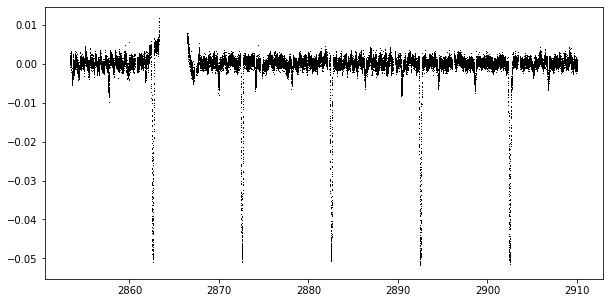

In [26]:
print(len(ph_original), len(times_original), len(flux_original_sub_period_a), len(model), len(ph_cut), len(flux_cut))
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(time_detrended_sig_rem,flux_detrended_sig_rem,',k')
#plt.xlim(-0.1,0.1)
plt.show()

In [27]:
np.median(err_cut)

MaskedNDArray(0.00076063, dtype=float32)

37466 37466 37466 37466 -0.013 0.013


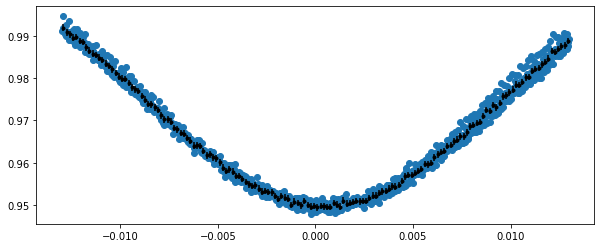

In [28]:
# for primary
def prepare_data_elcipse(time, phase, flux, err, start_ph, end_ph):

    print (len(time), len(phase), len(flux), len(err), start_ph, end_ph)
    
    df = pd.DataFrame({'time':time,'phase':phase, 'flux':flux, 'err':err})

    df_in_phase = df[(df['phase'] > start_ph) & (df['phase'] < end_ph) ]
    
    return df_in_phase


# time_detrended_sig_rem, flux_detrended_sig_rem

5
df_in_phase = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut)*[0.00076063], -0.013, 0.013) #-0.315, -0.0863)        

ph_primary0  = df_in_phase.phase
flux_primary0 = df_in_phase.flux + 1
err_primary0 = df_in_phase.err


def run_binning(x,y,period=1.,yerr=None,nbins=100):
    # Binning function -- takes into account aliasing and error
    # Propogation on errorbins
    x = np.array(x)
    y = np.array(y)
    
    finite_mask = np.isfinite(x) * np.isfinite(y)
    
    x = x[finite_mask]
    y = y[finite_mask]
    yerr = yerr[finite_mask]
    
    bwidth = 1./nbins
    
    phStart,phStop = np.nanmin(x), np.nanmax(x)
    
    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
    
    bins =  bins[:-1] + 0.5*bwidth
    
    return bins,bin_means,bin_errs

# period_9, t0_9

ph_binned,flux_binned,err_binned = run_binning(ph_primary0,flux_primary0,period_9,yerr=err_primary0,nbins=6000)

fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0, zorder = -2)

ph_primary = ph_primary0 #ph_binned
flux_primary = flux_primary0#flux_binned
err_primary = err_primary0#err_binned


In [29]:
# alpha0 + alpha1 * (1 - ( 1 - np.exp( 1 - np.cosh( (x - t0)/ d ))))**Tau

def model_fit(x, alpha0, alpha1, t0, d, Tau):
    
    cosh_term = np.cosh( (x - t0) /d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    return model 


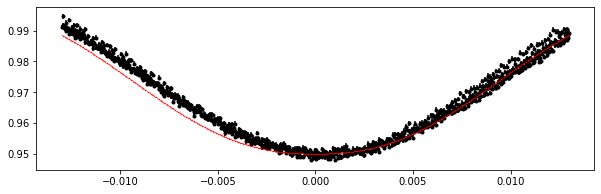

In [30]:
fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau


plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

plt.plot(ph_primary, model_fit(ph_primary, 1, -0.05, 0.00, 0.008, 1.2), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')



In [31]:
start_vals = [1, -0.05, 0.00, 0.008, 1.2]

pos = list(get_starting_positions(start_vals,nwalkers=128))[0]

nwalkers = 128
ndim = len(start_vals)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_primary, flux_primary, err_primary))

sampler.run_mcmc(pos, 2000, progress=True)

100%|███████████████████████████████████████| 2000/2000 [01:49<00:00, 18.22it/s]


State([[ 1.00436795e+00 -5.45312149e-02  4.13251565e-04  8.69611561e-03
   9.79264533e-01]
 [ 1.00733546e+00 -5.77033904e-02  4.15535974e-04  9.13702107e-03
   9.47979737e-01]
 [ 1.00400645e+00 -5.42739938e-02  4.13688588e-04  8.66820144e-03
   9.68495129e-01]
 [ 1.00524107e+00 -5.54567703e-02  4.22315843e-04  8.85176873e-03
   9.63928348e-01]
 [ 1.00792533e+00 -5.83659308e-02  4.18876664e-04  9.28692684e-03
   9.29224562e-01]
 [ 1.00499001e+00 -5.51542042e-02  4.07887674e-04  8.75226845e-03
   9.81192783e-01]
 [ 1.00468725e+00 -5.48917811e-02  4.15347856e-04  8.73090141e-03
   9.77313683e-01]
 [ 1.00597968e+00 -5.61574256e-02  4.16840343e-04  8.93775911e-03
   9.64581449e-01]
 [ 1.00676730e+00 -5.70382735e-02  4.10277758e-04  9.04222667e-03
   9.56642356e-01]
 [ 1.00658246e+00 -5.68241693e-02  4.22857328e-04  9.05116941e-03
   9.52185259e-01]
 [ 1.00605971e+00 -5.63405798e-02  4.16880803e-04  8.95881478e-03
   9.59484113e-01]
 [ 1.00573489e+00 -5.59598192e-02  4.16384007e-04  8.895230

In [32]:
tau = sampler.get_autocorr_time(tol=0)
print (tau)

[148.58512513 150.01578167  42.93784167 155.75388744 158.88801614]


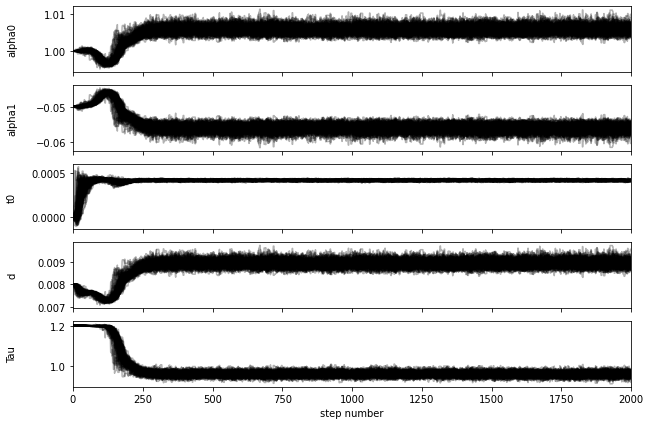

In [33]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["alpha0", "alpha1", "t0", "d", "Tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [34]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(12800, 5)


In [35]:
#import corner
#
#fig = corner.corner(
#    flat_samples)

1.005816747213494
-0.05608774637959878
0.00041889344150289397
0.008930417568479612
0.9591866844653891


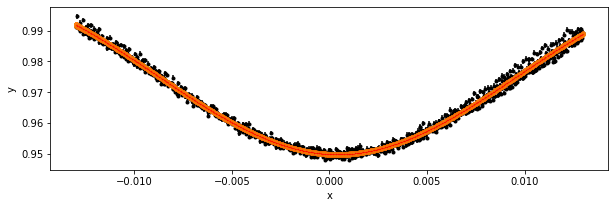

In [36]:
fig = plt.subplots(figsize=(10, 3), sharex=True)


mean_alpha0 = np.median(flat_samples[:,0])
mean_alpha1 = np.median(flat_samples[:,1])
mean_t0 = np.median(flat_samples[:,2])
mean_d = np.median(flat_samples[:,3])
mean_Tau = np.median(flat_samples[:,4])

print(mean_alpha0)
print(mean_alpha1)
print(mean_t0)
print(mean_d)
print(mean_Tau)

inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(ph_primary, model_fit(ph_primary, sample[0], sample[1], sample[2], sample[3], sample[4]), "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)

plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

plt.plot(ph_primary, model_fit(ph_primary, mean_alpha0, mean_alpha1,mean_t0, mean_d, mean_Tau), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

In [37]:

# now that we have the best fit model, we fit this model to each individual eclipse using mcmc
# the free parameters are t0, alpha0 and alpha1, the rest are fixed by phase folded model

def log_prior_fitting(theta):
    alpha0, alpha1, t0 = theta  
    if  (0 < alpha0 < 10) and ( -5 < alpha1 < 0) and (-0.5 < t0 < 0.5):
        return 0.0
    return -np.inf


def log_likelihood_fitting(theta, x, y, yerr):
    
    alpha0, alpha1, t0 = theta
        
    cosh_term = np.cosh( (x - t0) /mean_d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), mean_Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability_fitting(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr)

    return lnp


def get_starting_positions_fitting(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


In [38]:
time_primary  = df_in_phase.time
ph_primary  = df_in_phase.phase
flux_primary = df_in_phase.flux
err_primary = df_in_phase.err

Creating new manifest file


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 959.90it/s]


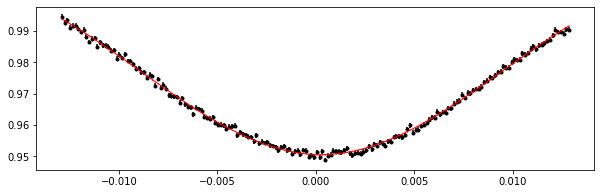

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 951.13it/s]


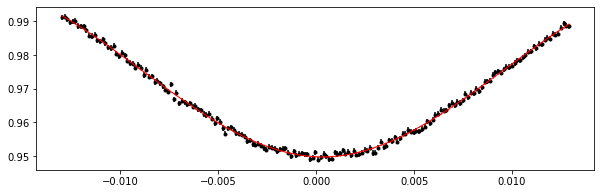

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 956.63it/s]


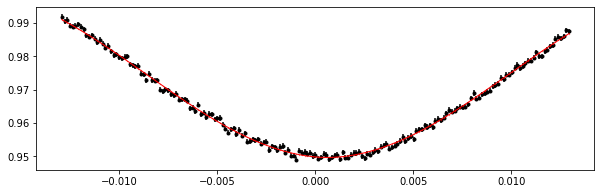

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 954.68it/s]


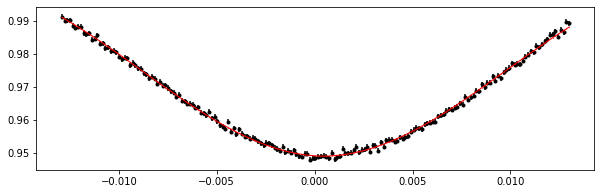

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 960.46it/s]


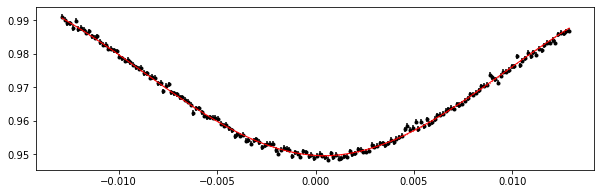

In [39]:
from os.path import basename, exists
import sys 
import csv

tr_index = range(0,3000)

outfile_path = '/Users/neisner/Documents/projects/fluffy/reanalysed/nineday_orig_period/mcmc_etvs_9d_{}.csv'.format(section_number+1)

if exists('{}'.format(outfile_path)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()

else:
    print("Creating new manifest file")
    sys.stdout.flush()
    
    metadata_header = ["number", 'epoch', 't0', 'alpha1', 'alpha2', 'd', 'Tau', 'std']
          
    with open('{}'.format(outfile_path), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

manifest_table = pd.read_csv('{}'.format(outfile_path))

number_done = manifest_table['number']

for i in tr_index:
    if not np.isin(i,number_done):
        
        transit_time = t0_9+(period_9*i)
        
        x = np.array(time_primary)
        y = np.array(flux_primary) + 1
        yerr = np.array(err_primary)
        
        mask = (x > (transit_time - (0.1*period_9))) & (x < (transit_time + (0.1*period_9))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])

        finite_mask = np.isfinite(x) * np.isfinite(y)
        
        x = np.array(x[finite_mask])
        y = np.array(y[finite_mask])
        yerr = np.array(yerr[finite_mask])
        
        x = np.array([-0.5+( ( t - t0_9-0.5*period_9) % period_9) / period_9 for t in x])
        
        if len(x) > 20:
            # starting vals alpha0, alpha1, t0
            
            #mean_alpha0
            #mean_alpha1
            #mean_t0
            #mean_d
            #mean_Tau


            start_vals = [mean_alpha0, mean_alpha1, mean_t0]
    
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            
            mean_alpha0_fit = np.nanmedian(flat_samples2[:,0])
            mean_alpha1_fit = np.nanmedian(flat_samples2[:,1])
            mean_t0_fit = np.nanmedian(flat_samples2[:,2])
            stdv_t0_fit = np.nanstd(flat_samples2[:,2])
              
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)
            plt.plot(x, model_fit(x, mean_alpha0_fit, mean_alpha1_fit,mean_t0_fit, mean_d, mean_Tau), lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
            with open('{}'.format(outfile_path), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit, mean_alpha0_fit, mean_alpha1_fit, mean_d, mean_Tau, stdv_t0_fit])
        else:
            continue
    else:
        print ("Number {} has already been completed -- skip".format(i))
        
    #fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
#
    #samples = sampler2.get_chain()
    #labels = ["alpha0", "alpha1", "t0", "d", "Tau"]
    #for i in range(ndim):
    #    ax = axes[i]
    #    ax.plot(samples[:, :, i], "k", alpha=0.3)
    #    ax.set_xlim(0, len(samples))
    #    ax.set_ylabel(labels[i])
    #    ax.yaxis.set_label_coords(-0.1, 0.5)
    #
    #axes[-1].set_xlabel("step number");
    #
    #mean_alpha0 = np.median(flat_samples2[:,0])
    #mean_alpha1 = np.median(flat_samples2[:,1])
    #mean_t0 = np.median(flat_samples2[:,2])
#
    #
    #print(mean_alpha0)
    #print(mean_alpha1)
    #print(mean_t0)

    

<IPython.core.display.Javascript object>


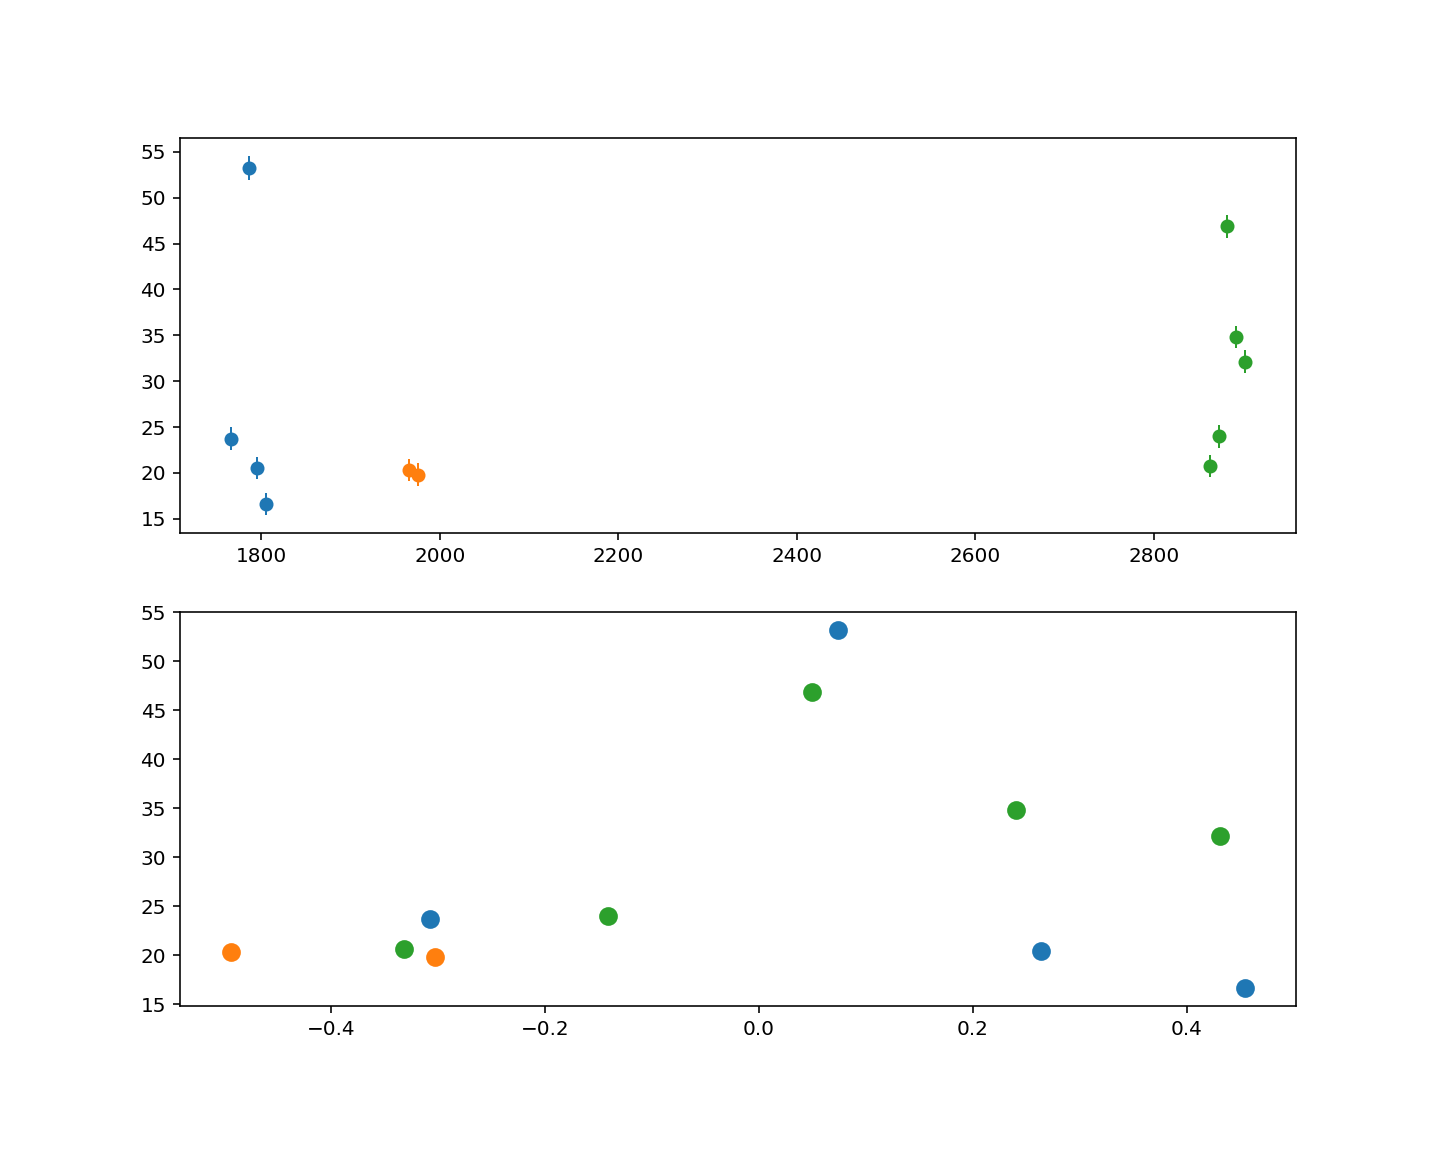

In [96]:
period = 52.3 #52.993
t0 = 1781.64



fig, ax = plt.subplots(2,1, figsize=(10, 8))

shift_all = []
epoch_all = []

for i in [0,1, 2]:
    in_df = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/nineday_orig_period/mcmc_etvs_9d_{}.csv'.format(i+1))
                        
    in_df['midpoint'] = in_df['epoch'] + (in_df['t0']*period)
    in_df['shift_mins'] = in_df['t0']*period*24*60
    
    shift = in_df['shift_mins']
    epoch = in_df['epoch']
    stv = in_df['std']*period*24*60
    
    #mask = (epoch > 1962) & (epoch < 1970)
    shift_all.append(shift)
    epoch_all.append(epoch)
    
    ax[0].errorbar(epoch, shift, yerr = stv, marker = 'o', lw = 0, elinewidth = 1)
    
    phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in epoch])
    
    ax[1].scatter(phased,shift, s =70, alpha = 1)


plt.show()


shift_all = np.hstack(shift_all)
epoch_all = np.hstack(epoch_all)


<IPython.core.display.Javascript object>


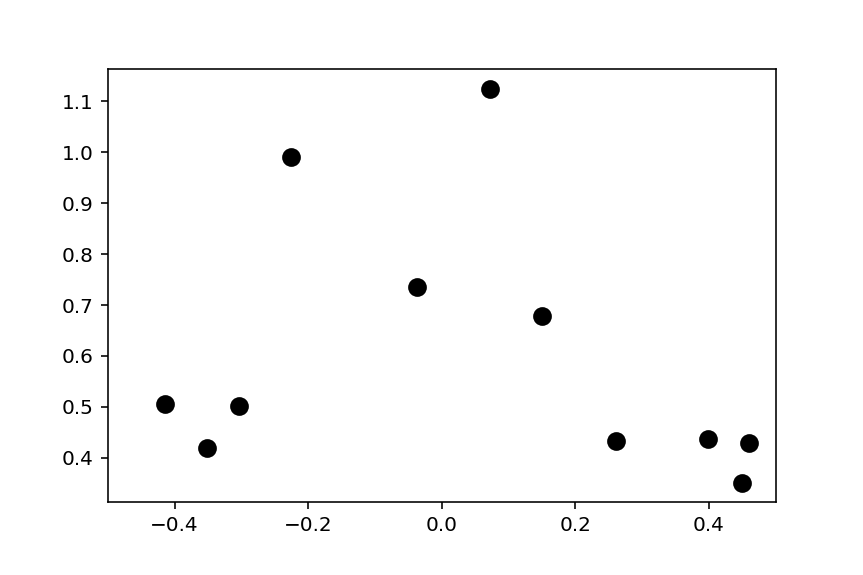

(-0.5, 0.5)

In [52]:
period = 52.993
t0 = 1781.64

fig, ax = plt.subplots()

phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in epoch_all])

plt.scatter(phased,shift_all, s =70, alpha = 1, c = 'k')

plt.show()
plt.xlim(-0.5,0.5)



<IPython.core.display.Javascript object>


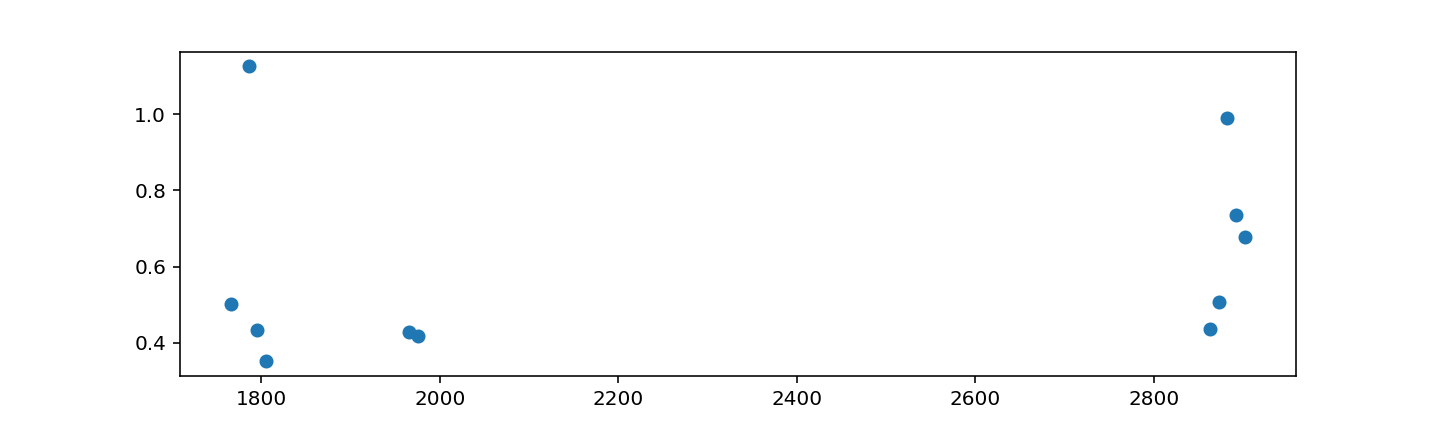

In [53]:
%matplotlib notebook 


fig = plt.subplots(figsize=(10, 3), sharex=True)

plt.errorbar(epoch_all, shift_all, marker = 'o', lw = 0, elinewidth = 1)

# period_4 =  4.09175
# t0_4 = 1765.17
# 
# for i in range(0,1200):
#     plt.axvline(t0_4 + (period_4 * i), color = 'gold', alpha = 0.4)

plt.show()


<IPython.core.display.Javascript object>


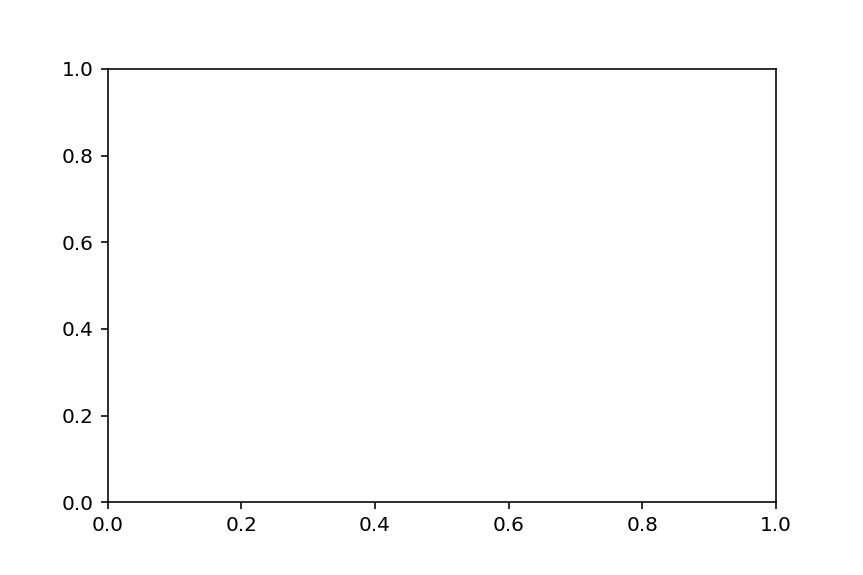

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [59]:
period = 52.992
t0 = 1781.64

fig, ax = plt.subplots()

phased_masked = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in epoch[~mask]])
phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in epoch])

plt.scatter(phased,shift, s =70, alpha = 1, c = 'r')
plt.scatter(phased_masked,shift[~mask], s =70, alpha = 1, c = 'k')

plt.show()
plt.xlim(-0.5,0.5)

<IPython.core.display.Javascript object>


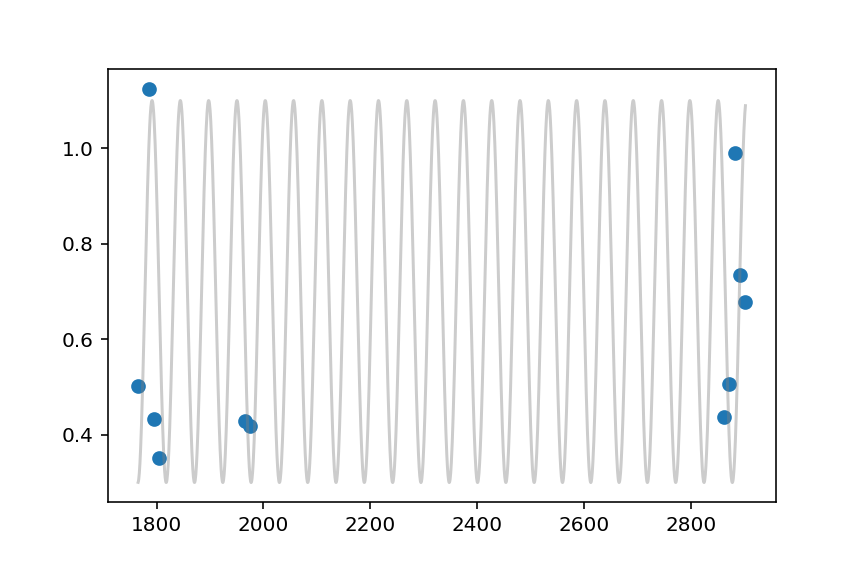

In [83]:
fig, ax = plt.subplots()

plt.scatter(epoch_all,shift_all, s =40, alpha = 1)

period = 52.992
t0 = 1781.64

freq= 1/period

#xstretch = 0.2
yshift = 0.7
phase = np.pi/2 + 1.2

x = np.linspace(np.min(epoch_all),np.max(epoch_all), 2000) 
y = 0.4*(np.sin(2*np.pi * freq * x + phase)) + yshift

plt.plot(x,y, alpha = 0.4, color = 'grey')

#plt.xlim(-0.1,0.1)
#plt.xlim(2800,3000)

In [58]:
period

52